In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('deep'))
plt.rcParams['figure.figsize'] = (20 , 10)


## derivative of a fn with single input:


Slope at 3: 14.011999999999247


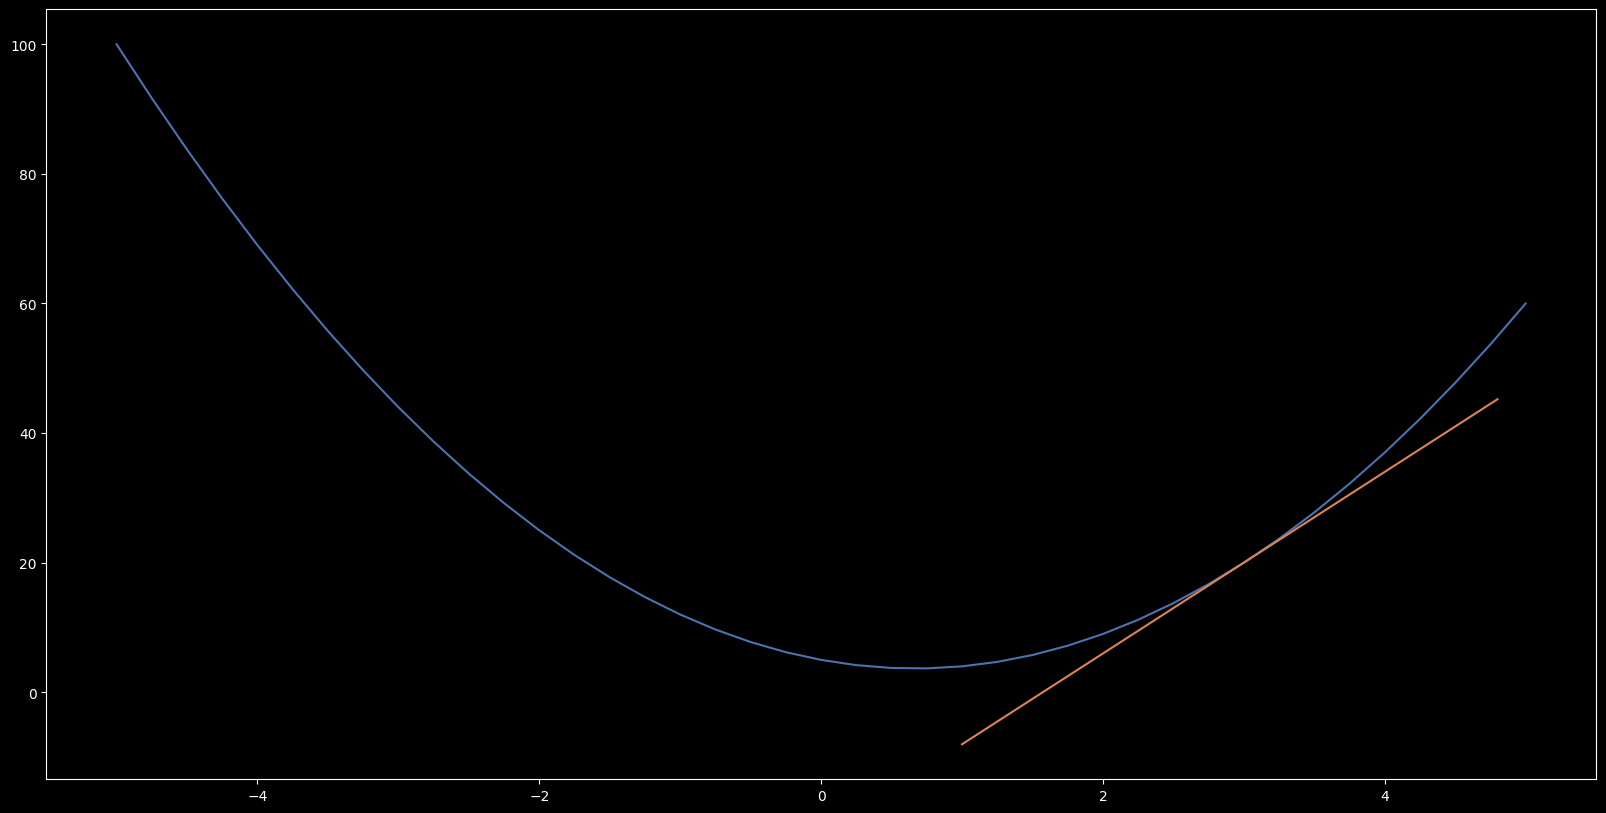

In [63]:
x = np.arange(-5,5.25 , 0.25)
def f(x):
    return 3*x**2 - 4*x + 5

#plot the derivative at a point:
xi = 3
delta = 0.004

yd = (f(xi + delta) - f(xi)) / delta
c = f(xi) - (yd * xi)

xirange = np.arange(xi - 2 , xi + 2 , 0.2)
tangent = xirange * yd + c

print(f"Slope at {xi}: {yd}")
plt.plot(x , f(x))
plt.plot(xirange , tangent)
plt.show()

## derivative with multiple inputs:


In [64]:
a =2 
b = -3.0 
c = 10
d = a * b + c
b += 0.001
d1 = a * b + c
slope = (d1 - d) / a
print(f"{slope}")

0.0009999999999998899


In [65]:
class Value():
    def __init__(self , data , children = () , _op = "", label = "" , grad = 0):
        self.data = data
        self.children = set(children)
        self._op = _op
        self.label = label
        self.grad = 0
         


    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self , other):
        return Value(self.data + other.data , (self , other) , "+")
    
    def __mul__(self , other):
        return Value(self.data * other.data , (self , other) , "*")
    
    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out =  Value(t , (self,) , 'tanh')
        return out
    


a = Value(2.0 , label = 'a')
b = Value(-3.0 , label = 'b')
c = Value(10 , label = 'c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2 , label= 'f')
g = e * f; g.label = 'g'
g

Value(data = -8.0)

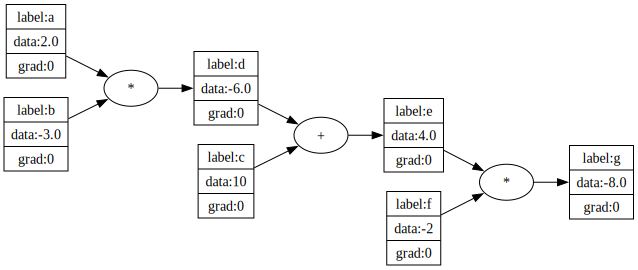

In [66]:
#plot the operations graph:
from graphviz import Digraph

def trace(root):
    nodes , edges = set() , set()
    def build(node):
        # print(node)
        if node not in nodes:
            nodes.add(node)
            for child in node.children:
                edges.add((child , node))
                build(child)
    build(root)
    return nodes , edges

def drawg(root):
    dot = Digraph(format = 'svg' , graph_attr={'rankdir':'LR'})

    nodes , edges = trace(root)

    for node in nodes:
        uid = str(id(node))
        dot.node(name = uid , label = f"label:{node.label} | data:{node.data} | grad:{node.grad}" , shape = 'record')

        if node._op:
            dot.node(name = uid + node._op , label = node._op)
            dot.edge(uid + node._op , uid)

    for n1 , n2 in edges:
        dot.edge(str(id(n1)) , str(id(n2)) + n2._op)

    return dot


# for node in e.children:
#     print(node)
drawg(g)

In [67]:
#forward-pass:
e.grad = -2
f.grad = 4
c.grad = -2
d.grad = -2
a.grad = 6
b.grad = -4

lr = 0.01

a.data+= lr * a.grad
b.data+= lr * b.grad
c.data+= lr * c.grad
f.data+= lr * f.grad

d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
g = e * f; g.label = 'g'
g

Value(data = -7.286496)

In [68]:
def lol():
    a = Value(2.0 , label = 'a')
    b = Value(-3.0 , label = 'b')
    c = Value(10 , label = 'c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2 , label= 'f')
    g = e * f; g.label = 'g'
    

    h = 0.001
    a = Value(2.0 , label = 'a')
    # a.data+= h
    b = Value(-3.0 , label = 'b')
    b.data+= h
    c = Value(10 , label = 'c')
    # c.data += h
    d = a*b
    # d.data+=h
    e = d + c
    # e.data+=h
    f = Value(-2 , label= 'f')
    # f.data+= h
    g2 = e * f
    
    return (g2.data - g.data) / h
lol()

-3.9999999999995595

# Propagation through a neuron:


Text(0.5, 1.0, 'tanh')

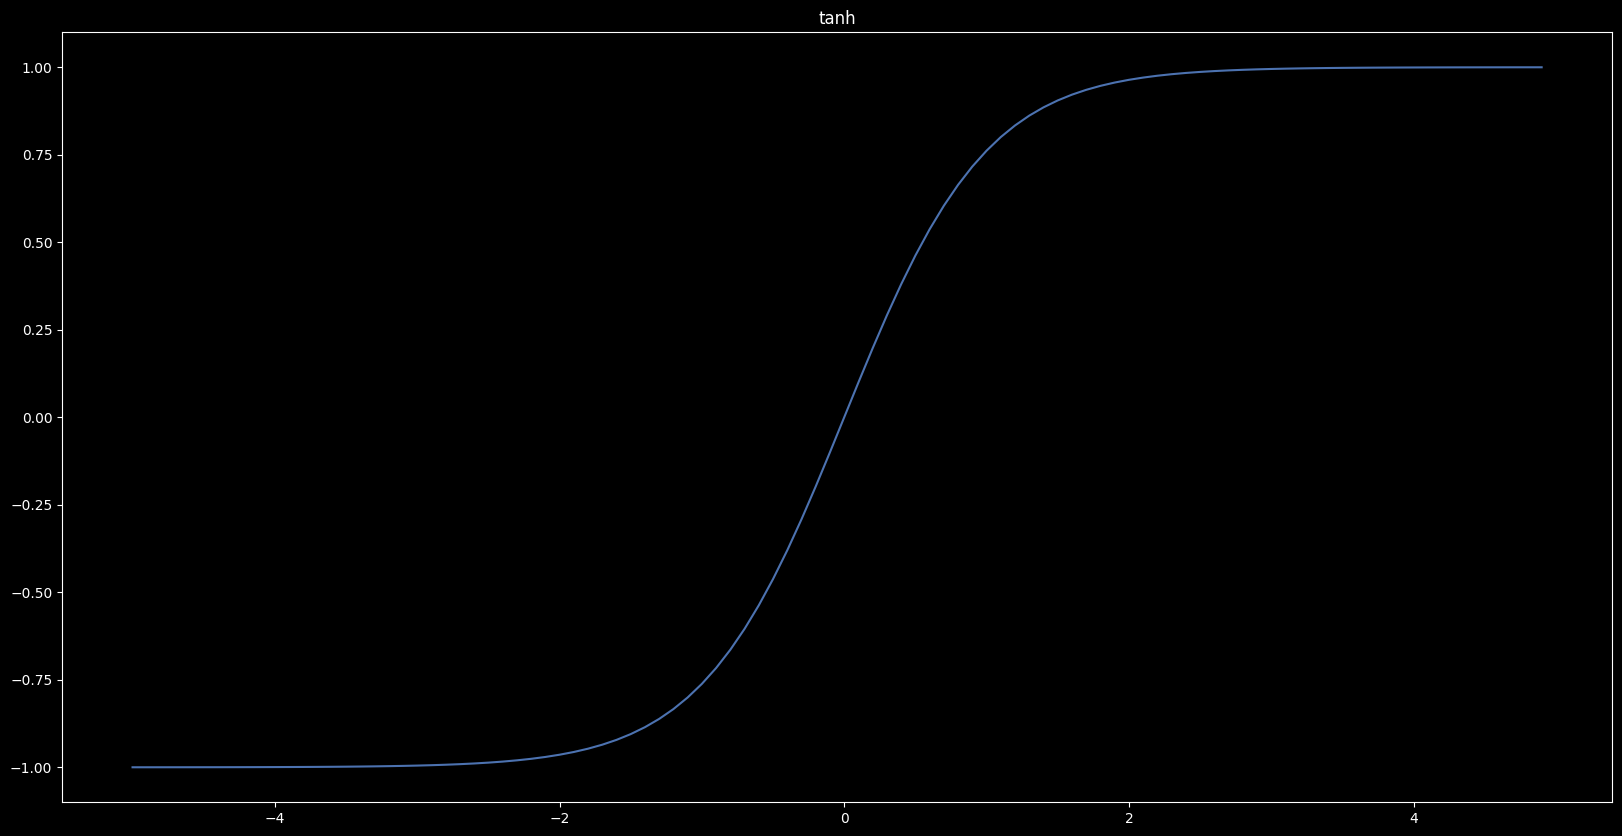

In [73]:
#plot tanh
x = np.arange(-5 , 5, 0.1)
y = np.tanh(x)
plt.plot(x , y)
plt.title('tanh')

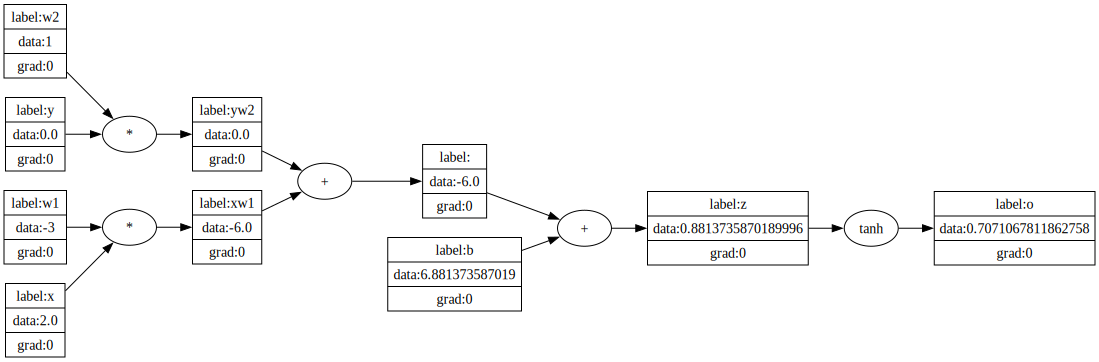

In [75]:
#inputs:
x = Value(2.0 , label = 'x')
y = Value(0.0 , label = 'y')

#weights:
w1 = Value(-3 , label = 'w1')
w2 = Value(1 , label = 'w2')
#bias
b = Value(6.881373587019 , label = 'b')

#matmul:

xw1 = x * w1; xw1.label = 'xw1'
yw2 = y * w2; yw2.label = 'yw2'
z = xw1 + yw2 + b; z.label = 'z'
o = z.tanh(); o.label = 'o'
drawg(o)